# **MODELING AND EVALUATION NOTEBOOK**

## Objectives

* Fit and evaluate a regression model to predict the sale price of a house

## Inputs

* outputs/datasets/collection/house_prices_records.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict sale price
* Feature importance plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues'

# Load Data

Load data from the "collections" folder as the pipeline has to handle cleaning and engineering by itself.

In [4]:
! pip install pandas==1.4.2
! pip install numpy==1.23.5 # to resolve compatibility errors with other packages

In [5]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/house_prices_records.csv")

print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

# ML Pipeline with all data

## ML Pipeline: For Data Cleaning and Feature Engineering, Modelling and Hyperparameter Optimization

In [6]:
! pip install feature-engine==1.0.2

In [7]:
! pip install xgboost==1.2.1

In [8]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from feature_engine.selection import DropFeatures
from feature_engine.imputation import  MeanMedianImputer
from feature_engine.imputation import  CategoricalImputer
from feature_engine.imputation import  ArbitraryNumberImputer

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

def PipelineOptimization():
    pipeline_base = Pipeline([
        # Data Cleaning
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF', 'MasVnrArea'])),
        ("CategoricalImputer_Unf", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['BsmtFinType1', 'GarageFinish'])),
        ("CategoricalImputer_No", CategoricalImputer(imputation_method='missing', fill_value='No', variables=['BsmtExposure'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])),
        # Feature Engineering
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['TotalBsmtSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables=['BsmtUnfSF', 'LotArea'])),
        ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),
         # took out scaler, feat_selection and model
    ])

    return pipeline_base


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [9]:
def PipelineRgr(model): # new def PipelineRgr
    pipeline_base = Pipeline([    
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base


Custom Class for Hyperparameter Optimization from Code Institute:

In [10]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineRgr(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train Test Set

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


Fit and transform train and test set

In [12]:
pipeline = PipelineOptimization()
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


(1168, 17) (1168,) (292, 17) (292,)


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


---

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm

In [13]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(),
    "XGBRegressor": XGBRegressor(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBRegressor": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "GradientBoostingRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
}

Quick GridSearch CV - Binary Classifier

In [14]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring='r2',
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
4,GradientBoostingRegressor,0.643677,0.770972,0.816705,0.064208
5,ExtraTreesRegressor,0.61982,0.753094,0.823031,0.069646
3,RandomForestRegressor,0.61857,0.719694,0.786709,0.056232
6,AdaBoostRegressor,0.626181,0.704365,0.778725,0.051736
1,XGBRegressor,0.637822,0.677041,0.711843,0.028376
2,DecisionTreeRegressor,0.352237,0.566243,0.65901,0.110791
0,LogisticRegression,0.435422,0.506164,0.573979,0.05525


The result suggests that GradientBoosterRegressor is giving the best result. Therefore, it will be explored in more detail.

### Do an extensive search on the most suitable algorithm, ie GradientBoosterRegressor, to find the best hyperparameter configuration.

In [16]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

params_search = {"GradientBoostingRegressor":{
       'model__learning_rate': [0.01, 0.05, 0.1], # tried also with 0.2, didnt improve mean score 
       'model__max_depth': [3, 5], 
       'model__n_estimators': [50, 75, 100], 
       'model__min_samples_split': [25, 50], 
       'model__min_samples_leaf': [1, 5, 10], 
       #'model__random_state': [None, 2, 10], removed as it severly impacts computation time
       'model__subsample': [0.8], 
       'model__max_leaf_nodes': [50, 100], 
   }}

Extensive GridSearch CV - Binary Classifier

In [17]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search) 
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Check results

In [18]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__subsample
121,GradientBoostingRegressor,0.738276,0.804098,0.84174,0.040309,0.05,5,50,10,25,75,0.8
139,GradientBoostingRegressor,0.738276,0.804098,0.84174,0.040309,0.05,5,100,10,25,75,0.8
142,GradientBoostingRegressor,0.739202,0.803032,0.839053,0.040543,0.05,5,100,10,50,75,0.8
124,GradientBoostingRegressor,0.739202,0.803032,0.839053,0.040543,0.05,5,50,10,50,75,0.8
106,GradientBoostingRegressor,0.740063,0.802138,0.835814,0.037705,0.05,3,100,10,50,75,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...
27,GradientBoostingRegressor,0.421716,0.446925,0.485447,0.024193,0.01,3,100,5,50,50,0.8
18,GradientBoostingRegressor,0.430594,0.444858,0.471012,0.016193,0.01,3,100,1,25,50,0.8
0,GradientBoostingRegressor,0.430594,0.444858,0.471012,0.016193,0.01,3,50,1,25,50,0.8
21,GradientBoostingRegressor,0.42235,0.443847,0.471064,0.017607,0.01,3,100,1,50,50,0.8


Get best model name programmatically

In [19]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [20]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.05,
 'model__max_depth': 5,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 10,
 'model__min_samples_split': 25,
 'model__n_estimators': 75,
 'model__subsample': 0.8}

Define the best regressor pipeline

In [21]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=5,
                                           max_leaf_nodes=50,
                                           min_samples_leaf=10,
                                           min_samples_split=25,
                                           n_estimators=75, random_state=0,
                                           subsample=0.8))])

## Assess feature importance

In [22]:
X_train.head(3)

,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt
618,0.0,3.0,0,48,0,42.118879,285.045628,0,0,108.138800,90.0,452.0,108,5,9,495.850351,2007
870,0.0,2.0,1,0,0,29.899833,133.391135,0,1,81.240384,60.0,0.0,0,5,5,280.785318,1962
92,0.0,2.0,1,713,1,12.767145,176.328952,0,1,115.585466,80.0,0.0,0,7,5,276.257124,1921


In [23]:
! pip install matplotlib==3.3.1
! pip install seaborn==0.11.0

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', 'GarageArea', '2ndFlrSF']


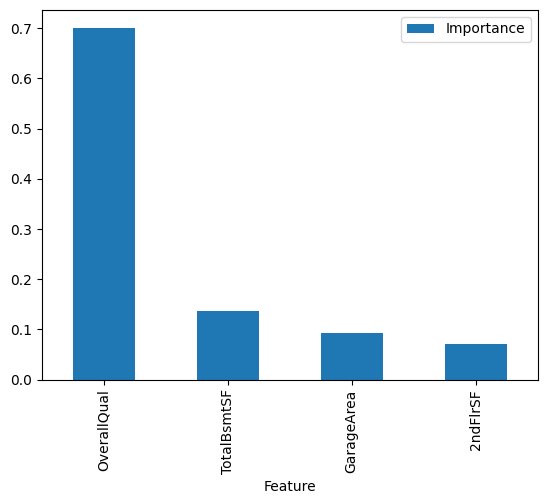

In [24]:
import matplotlib.pyplot as plt

df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


best_features = df_feature_importance['Feature'].to_list()


print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [25]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style('whitegrid')

# %matplotlib inline

# data_cleaning_feat_eng_steps = 10 
# columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
#                                         .transform(X_train)
#                                         .columns)

# best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# # create DataFrame to display feature importance
# df_feature_importance = (pd.DataFrame(data={
#           'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
#           'Importance': best_regressor_pipeline['model'].feature_importances_})
#   .sort_values(by='Importance', ascending=False)
#   )

# # Most important features statement and plot
# print(f"* These are the {len(best_features)} most important features in descending order. "
#       f"The model was trained on them: \n{best_features}")

# df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
# plt.show()

## Evaluate Pipeline on Train and Test Sets



Measure how close regression line is to data points with mean and absolute error

In [26]:
from sklearn.metrics import mean_squared_error

predict = best_regressor_pipeline.predict(X_train)
print("Mean squared error")
mean_squared_error(y_train, predict)

Mean squared error


765465471.7345357

In [27]:
from sklearn.metrics import mean_absolute_error

predict = best_regressor_pipeline.predict(X_train)
print("Mean absolute error")
mean_absolute_error(y_train, predict)

Mean absolute error


18365.430081813887

In [28]:
from sklearn.metrics import r2_score

predict_test = best_regressor_pipeline.predict(X_train)
r2_score(y_train, predict)

0.8756747731999127

The R2 score of 0.87+ is a very good score and indicates a good fit for our model.

<AxesSubplot:ylabel='SalePrice'>

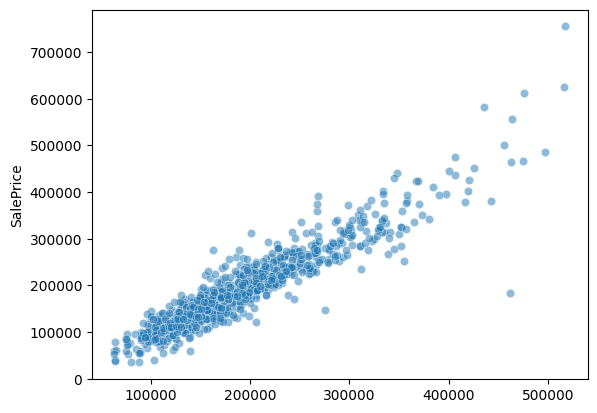

In [29]:
import seaborn as sns

sns.scatterplot(x=predict, y=y_train, alpha=0.5)

Data seems to have a quite clear correlation.

## Rewrite Pipeline with the best parameters

In [30]:
best_features

['OverallQual', 'TotalBsmtSF', 'GarageArea', '2ndFlrSF']

Pipeline for Data Cleaning and Feature Engineering

In [31]:
def PipelineOptimization():
    pipeline_base = Pipeline([
        # Data Cleaning
        # ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF'])), #, 'MasVnrArea'
        # ("CategoricalImputer_Unf", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['BsmtFinType1', 'GarageFinish'])),
        # ("CategoricalImputer_No", CategoricalImputer(imputation_method='missing', fill_value='No', variables=['BsmtExposure'])),
        # ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])),
        # Feature Engineering
        # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
        #                                             variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['TotalBsmtSF', 'GarageArea'])),
        # ("PowerTransformer", vt.PowerTransformer(variables=['BsmtUnfSF', 'LotArea'])),
        # ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

        # ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
        # method="spearman", threshold=0.6, selection_method="variance")),
         # took out scaler, feat_selection and model
    ])

    return pipeline_base

In [32]:
# def PipelineOptimization():
#     pipeline_base = Pipeline([
#         # Data Cleaning
#         ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
#         ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF', 'MasVnrArea'])),
#         ("CategoricalImputer_Unf", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['BsmtFinType1', 'GarageFinish'])),
#         ("CategoricalImputer_No", CategoricalImputer(imputation_method='missing', fill_value='No', variables=['BsmtExposure'])),
#         ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])),
#         # Feature Engineering
#         ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
#                                                      variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

#         ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['TotalBsmtSF', 'GarageArea'])),
#         ("PowerTransformer", vt.PowerTransformer(variables=['BsmtUnfSF', 'LotArea'])),
#         ("LogTransformer", vt.LogTransformer(variables=['1stFlrSF','GrLivArea'])),

#         ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
#          method="spearman", threshold=0.6, selection_method="variance")),
#          # took out scaler, feat_selection and model
#     ])

#     return pipeline_base

ML Pipeline for Modelling and Hyperparameter Optimization

In [33]:
def PipelineRgr(model): # new def PipelineRgr
    pipeline_base = Pipeline([    
        ("scaler", StandardScaler()),
        #("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Update Train and Test Sets with best features

In [34]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(5)

(1168, 4) (1168,) (292, 4) (292,)


,OverallQual,TotalBsmtSF,GarageArea,2ndFlrSF
618,9,495.850351,285.045628,0.0
870,5,280.785318,133.391135,0.0
92,5,276.257124,176.328952,0.0
817,8,439.843394,309.970670,0.0
302,7,433.785653,305.797920,0.0


In [35]:
best_model

'GradientBoostingRegressor'

In [36]:
best_parameters

{'model__learning_rate': 0.05,
 'model__max_depth': 5,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 10,
 'model__min_samples_split': 25,
 'model__n_estimators': 75,
 'model__subsample': 0.8}

Now we only apply the best parameters:

In [37]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

params_search = {"GradientBoostingRegressor":{ 
        'model__learning_rate': [0.05],
        'model__max_depth': [5],
        'model__max_leaf_nodes': [50],
        'model__min_samples_leaf': [10],
        'model__min_samples_split': [25],
        'model__n_estimators': [75],
        'model__subsample': [0.8],
   }}

In [38]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = 'r2',
           n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [39]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__subsample
0,GradientBoostingRegressor,0.738276,0.804098,0.84174,0.040309,0.05,5,50,10,25,75,0.8


Mean Score of 0.80 is still very good.

In [40]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(1168, 4) (1168,) (292, 4) (292,)


,OverallQual,TotalBsmtSF,GarageArea,2ndFlrSF
618,9,495.850351,285.045628,0.0
870,5,280.785318,133.391135,0.0
92,5,276.257124,176.328952,0.0


In [41]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=5,
                                           max_leaf_nodes=50,
                                           min_samples_leaf=10,
                                           min_samples_split=25,
                                           n_estimators=75, random_state=0,
                                           subsample=0.8))])

---

# Push files to Repo

The following files will be created and pushed to the repo:

* Train Set
* Test Set
* Modeling Pipeline
* Feature importance Plot

In [42]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_sale_price/v1'


## Train Set: Features And Target

In [43]:
print(X_train.shape)
X_train.head()

(1168, 4)


,OverallQual,TotalBsmtSF,GarageArea,2ndFlrSF
618,9,495.850351,285.045628,0.0
870,5,280.785318,133.391135,0.0
92,5,276.257124,176.328952,0.0
817,8,439.843394,309.970670,0.0
302,7,433.785653,305.797920,0.0


In [44]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [45]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [46]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: Features And Target

In [47]:
print(X_test.shape)
X_test.head()

(292, 4)


,OverallQual,TotalBsmtSF,GarageArea,2ndFlrSF
529,6,541.596143,193.645172,0.0
491,6,258.462952,108.556169,620.0
459,5,233.273633,148.929195,224.0
279,7,345.753788,200.542235,866.0
655,6,183.422323,117.449460,0.0


In [48]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [49]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [50]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Pipeline

In [51]:
best_regressor_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=5,
                                           max_leaf_nodes=50,
                                           min_samples_leaf=10,
                                           min_samples_split=25,
                                           n_estimators=75, random_state=0,
                                           subsample=0.8))])

In [52]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v1/best_regressor_pipeline.pkl']

## Feature Importance Plot

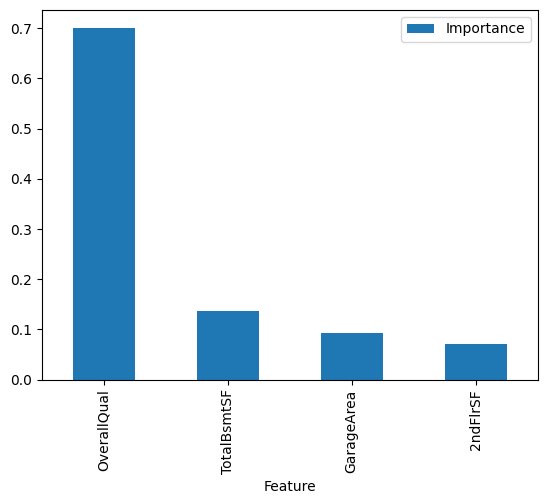

In [53]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

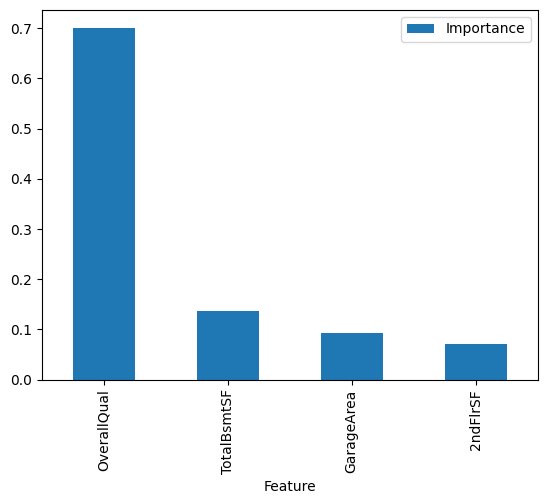

In [54]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature_importance.png', bbox_inches='tight')

This completes the notebook.